<a href="https://colab.research.google.com/github/saumya0303/attack_image/blob/master/PGD_Attack_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
image = tf.Variable(tf.zeros((299, 299, 3)))

In [0]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

In [0]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [0]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

In [0]:
import json
import matplotlib.pyplot as plt
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

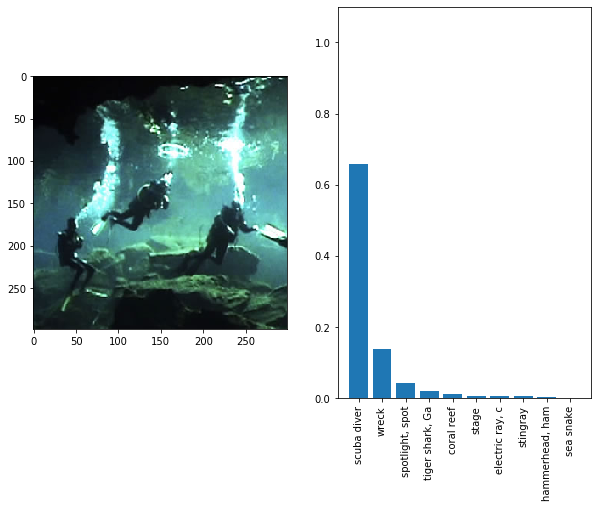

In [0]:
import PIL
import numpy as np
#give some url from imagenet dataset
img_path, _ = urlretrieve('http://4.bp.blogspot.com/_HaQt8-pBKFY/TFiTvoW7JJI/AAAAAAAALVg/liegsnj2ACE/s1600/12.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)
classify(img, correct_class=img_class)

In [0]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

In [0]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

In [0]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [0]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 65 # "sea snake"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.00202986
step 20, loss=0.00110934
step 30, loss=0.000777062
step 40, loss=0.000593844
step 50, loss=0.000475651
step 60, loss=0.000389262
step 70, loss=0.000330394
step 80, loss=0.000286061
step 90, loss=0.000251977
step 100, loss=0.000225399


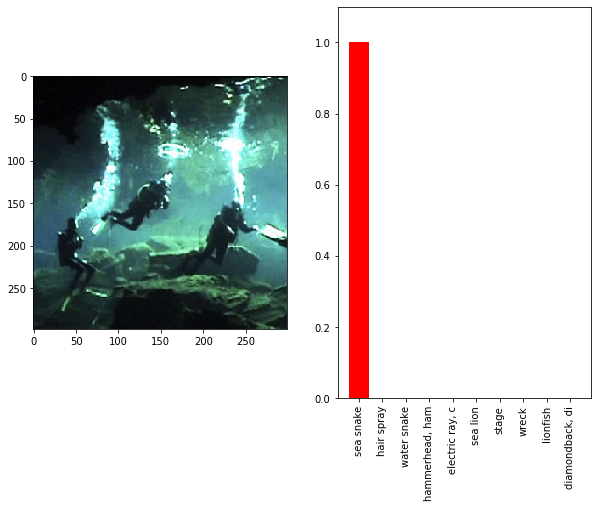

In [0]:
classify(adv, correct_class=img_class, target_class=demo_target)